In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from tensorboardX import SummaryWriter

writer = SummaryWriter("logs")

class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv1d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv1d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm1d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv1d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x.to(torch.float32))
        return out

/home/visitor/anaconda3/envs/1DCNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MyDataset(Dataset):
    def __init__(self, data_dir, noisy_dir, is_train):
        self.x = None
        self.y = None
        f_list = os.listdir(data_dir)
        if is_train: 
            for idx in range(min(sample_num, len(f_list))):
                if self.x is None:
                    self.x = np.load(data_dir + str(idx+1) + '.npy')[:180, :]
                    self.y = np.load(noisy_dir + str(idx+1) + '.npy')[:180, :]
                else:
                    self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[:180, :]))
                    self.y = np.concatenate((self.y, np.load(noisy_dir + str(idx+1) + '.npy')[:180, :]))
        else:
            for idx in range(min(sample_num, len(f_list))):
                if self.x is None:
                    self.x = np.load(data_dir + str(idx+1) + '.npy')[180:, :]
                    self.y = np.load(noisy_dir + str(idx+1) + '.npy')[180:, :]
                else:
                    self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[180:, :]))
                    self.y = np.concatenate((self.y, np.load(noisy_dir + str(idx+1) + '.npy')[180:, :]))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


In [3]:
def batch_PSNR(img, imclean):
    print(img.shape)
    print(imclean.shape)
    mse = np.mean((imclean - img) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [20]:
device = torch.device("cpu")

parser = argparse.ArgumentParser(description="DnCNN")
parser.add_argument("--preprocess", type=bool, default=False, help='run prepare_data or not')
parser.add_argument("--batchSize", type=int, default=64, help="Training batch size")
parser.add_argument("--num_of_layers", type=int, default=17, help="Number of total layers")
parser.add_argument("--epochs", type=int, default=500, help="Number of training epochs")
parser.add_argument("--milestone", type=int, default=30, help="When to decay learning rate; should be less than epochs")
parser.add_argument("--lr", type=float, default=1e-3, help="Initial learning rate")
parser.add_argument("--outf", type=str, default=".", help='path of log files')
parser.add_argument("--mode", type=str, default="B", help='with known noise level (S) or blind training (B)')
parser.add_argument("--noiseL", type=float, default=25, help='noise level; ignored when mode=B')
parser.add_argument("--val_noiseL", type=float, default=25, help='noise level used on validation set')

opt = parser.parse_args(args=[])  

sample_num = 15
# 构建模型、优化器和损失函数
model = DnCNN(1).cuda()
# print(model)

optimizer = optim.Adam(model.parameters(), lr=0.00002)
criterion = nn.MSELoss(size_average=False)

clean_dataset = 'data/clean_npy/'
noisy_dataset = 'data/CNT_noisy_final/'

trian_data_dir = []
# train_dataset = MyDataset('data/clean_npy/', 'data/noisy_npy/', True)
train_dataset = MyDataset(clean_dataset, noisy_dataset, True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
step = 0
for epoch in range(opt.epochs):
    if epoch < opt.milestone:
        current_lr = opt.lr
    else:
        current_lr = opt.lr / 10.
    # set learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = current_lr
    # print('learning rate %f' % current_lr)
    # train
    for i, data in enumerate(train_loader):
        # training step
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        img_train = Variable(data[0].cuda()).unsqueeze(1).to(torch.float32)
        imgn_train = Variable(data[1].cuda()).unsqueeze(1).to(torch.float32)
        noise = Variable((data[1]-data[0]).cuda()).unsqueeze(1).to(torch.float32)
        out_train = model(imgn_train)
        # print((out_train - noise).shape)
        # print(criterion(out_train, noise))
        loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
        loss.backward()
        optimizer.step()
        # results
        model.eval()
        out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
        # psnr_train = batch_PSNR(out_train, img_train)
        # print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
        #     (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
        # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
        if step % 100 == 0:
            # Log the scalar values
            print(loss.item())
        # writer.add_scalar('loss', loss.item(), step)
            # writer.add_scalar('PSNR on training data', psnr_train, step)
        step += 1
    ## the end of each epoch
    model.eval()
    # validate
    psnr_val = 0
    
    val_dataset = MyDataset(clean_dataset, noisy_dataset, False)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
    for i, data in enumerate(val_loader, 0):
        img_val = torch.unsqueeze(data[0], 1)
        noise = data[1] - data[0]
        imgn_val = torch.unsqueeze(data[1], 1)
        img_val, imgn_val = Variable(img_val.cuda(), volatile=True), Variable(imgn_val.cuda(), volatile=True)
        out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
        # psnr_val += batch_PSNR(out_val, img_val)
    # psnr_val /= len(dataset_val)
    # print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
    # writer.add_scalar('PSNR on validation data', psnr_val, epoch)
    # log the images
    # out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
    # Img = utils.make_grid(img_train.data, nrow=8, normalize=True, scale_each=True)
    # Imgn = utils.make_grid(imgn_train.data, nrow=8, normalize=True, scale_each=True)
    # Irecon = utils.make_grid(out_train.data, nrow=8, normalize=True, scale_each=True)
    # writer.add_image('clean image', Img, epoch)
    # writer.add_image('noisy image', Imgn, epoch)
    # writer.add_image('reconstructed image', Irecon, epoch)
    # save model
    if step % 100 == 0:
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net-1.pth'))

/home/visitor/anaconda3/envs/1DCNN/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


50.029788970947266


/tmp/ipykernel_949836/3442912045.py:81: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_val, imgn_val = Variable(img_val.cuda(), volatile=True), Variable(imgn_val.cuda(), volatile=True)


0.6621655225753784
0.6204601526260376
0.5255988240242004
0.5000851154327393
0.5888689756393433
0.44213366508483887
0.41677188873291016
0.43133825063705444
0.41403841972351074
0.42749494314193726
0.4326997995376587
0.3898671269416809
0.41303274035453796
0.40201258659362793
0.402098149061203


KeyboardInterrupt: 

In [21]:
model_dncnn = DnCNN(1)
# model_dncnn.load_state_dict(torch.load("R-noisy-clean.pth"))
model_dncnn.load_state_dict(torch.load("net-1.pth"))

<All keys matched successfully>

In [22]:
model_dncnn.eval()
Tensor = torch.cuda.FloatTensor
input_A = Tensor(1, 1, 1000)

In [23]:
sample_num = 15
val_dataset = MyDataset(clean_dataset, 'data/noisy_npy/', False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [24]:
out = []
for i in range(len(val_dataset)):
    _, y = val_dataset[i]
    result = model_dncnn(torch.from_numpy(y).unsqueeze(0).unsqueeze(0)).detach().numpy()
    out.append(y - result[0][0])
    if (i+1) % 20 == 0:
        np.save("data/R-noisy-clean/{}".format(i//20+1), np.asarray(out)) # DnCNN-noisy-clean R-noisy-clean
        out = []
    

In [19]:
import matplotlib.pyplot as plt
# plt.plot(val_dataset[1][1]-result[0][0])
plt.plot(out[1])

IndexError: list index out of range

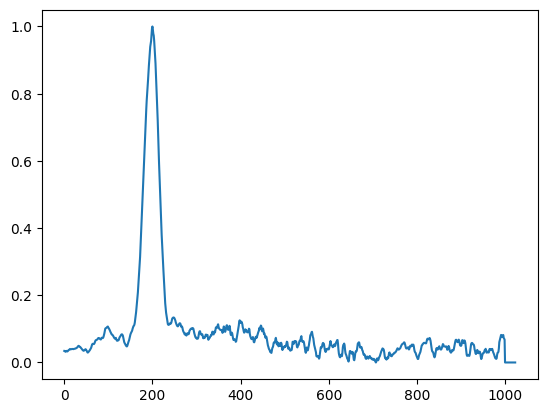

In [10]:
import matplotlib.pyplot as plt
plt.plot(val_dataset[1][1])

In [36]:
!pip install tensorboardX

/bin/bash: /home/visitor/anaconda3/envs/1DCNN/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.4 MB/s eta 0:00:00a 0:00:01
